# MNIST Handwritten Digit Recognition

# Importing libraries

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
import time
from sklearn.model_selection import GridSearchCV

try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
    from tensorflow.keras.utils import to_categorical
    tensorflow_available = True
except ImportError:
    tensorflow_available = False
    print("TensorFlow not available. CNN implementation will be skipped.")

# Loading the MNIST datasets

In [11]:
train_df = pd.read_csv('data.csv')
test_df = pd.read_csv('test.csv')


Display basic information about the dataset

In [12]:
print(f"Training dataset shape: {train_df.shape}")
print(f"Testing dataset shape: {test_df.shape}")

Training dataset shape: (60000, 785)
Testing dataset shape: (10000, 785)


Check for missing values

In [13]:
print(f"Missing values in training data: {train_df.isnull().sum().sum()}")
print(f"Missing values in test data: {test_df.isnull().sum().sum()}")

Missing values in training data: 0
Missing values in test data: 0


Display the distribution of digits in training data

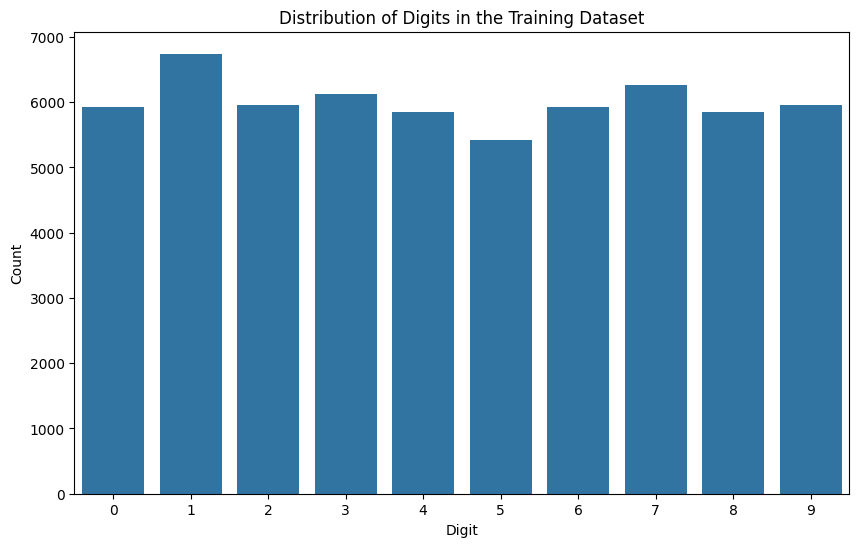

In [14]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=train_df)
plt.title('Distribution of Digits in the Training Dataset')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.show()

Prepare training data and test data

In [15]:
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values

In [16]:
X_test = test_df.values

Normalize pixel values (0-255) to range (0-1)

In [17]:
X_train = X_train / 255.0
X_test = X_test / 255.0

# Split data into training and testing sets (70% train, 30% test)

In [18]:
X_train_eval, X_test_eval, y_train_eval, y_test_eval = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42
)
print(f"Training evaluation set shape: {X_train_eval.shape}")
print(f"Testing evaluation set shape: {X_test_eval.shape}")

Training evaluation set shape: (42000, 784)
Testing evaluation set shape: (18000, 784)


# Visualize sample digits

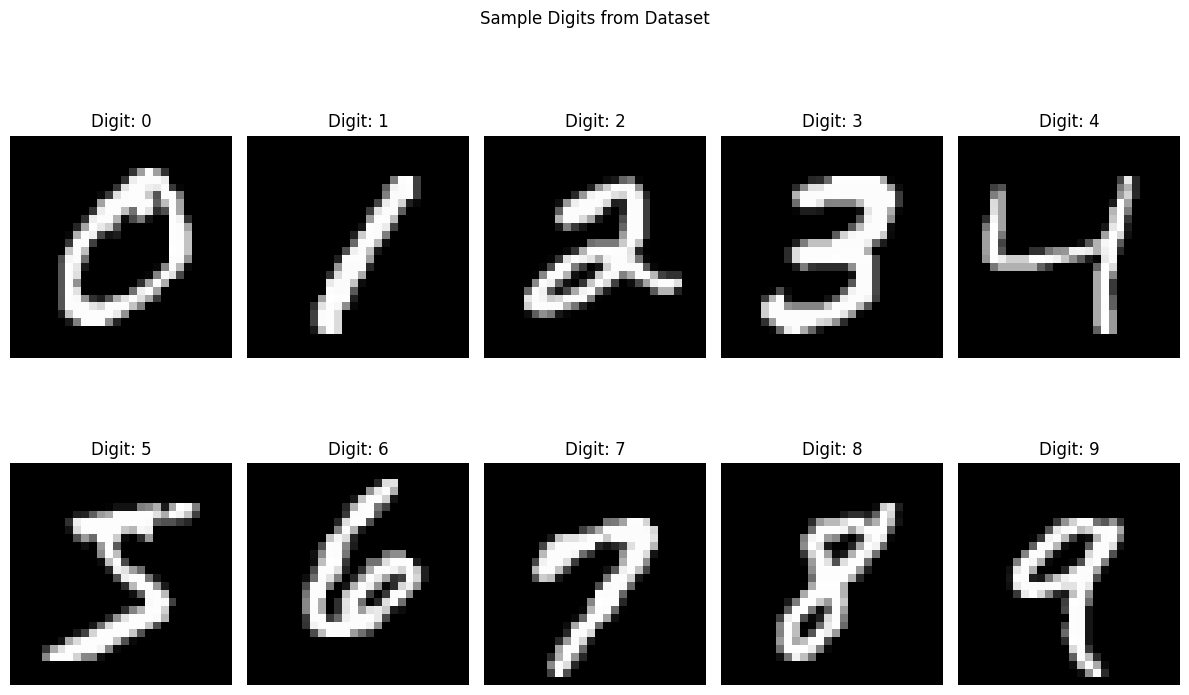

In [19]:
img_dim = int(np.sqrt(X_train.shape[1]))  # Should be 28 for MNIST
plt.figure(figsize=(12, 8))
for i in range(10):
    # Find first occurrence of digit i
    digit_idx = np.where(y_train == i)[0]
    if len(digit_idx) > 0:
        plt.subplot(2, 5, i+1)
        plt.imshow(X_train[digit_idx[0]].reshape(img_dim, img_dim), cmap='gray')
        plt.title(f'Digit: {i}')
        plt.axis('off')
    else:
        print(f"No examples of digit {i} found in training data")
plt.suptitle('Sample Digits from Dataset')
plt.tight_layout()
plt.show()

# KNN Implementation with K value optimization

In [20]:
print("\n--- KNN Implementation ---")
k_values = list(range(1, 16, 2))  # Test odd values from 1 to 15
knn_accuracies = []

start_time = time.time()
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_eval, y_train_eval)
    knn_pred = knn.predict(X_test_eval)
    knn_acc = accuracy_score(y_test_eval, knn_pred)
    knn_accuracies.append(knn_acc)
    print(f"K={k}, Accuracy: {knn_acc:.4f}")
knn_training_time = time.time() - start_time


--- KNN Implementation ---
K=1, Accuracy: 0.9706
K=3, Accuracy: 0.9701
K=5, Accuracy: 0.9686
K=7, Accuracy: 0.9672
K=9, Accuracy: 0.9660
K=11, Accuracy: 0.9641
K=13, Accuracy: 0.9627
K=15, Accuracy: 0.9611


# Find optimal K value

In [21]:
optimal_k = k_values[np.argmax(knn_accuracies)]
print(f"Optimal K value: {optimal_k}")

Optimal K value: 1


Train KNN with optimal K on full training data

In [22]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

Measure prediction time

In [23]:
start_time = time.time()
knn_pred_eval = knn.predict(X_test_eval)
knn_prediction_time = time.time() - start_time
knn_acc = accuracy_score(y_test_eval, knn_pred_eval)

print(f"KNN (K={optimal_k}) Accuracy: {knn_acc:.4f}")
print(f"KNN Training Time: {knn_training_time:.2f} seconds")
print(f"KNN Prediction Time: {knn_prediction_time:.2f} seconds")

KNN (K=1) Accuracy: 1.0000
KNN Training Time: 52.57 seconds
KNN Prediction Time: 8.35 seconds


# Plot K vs. Accuracy

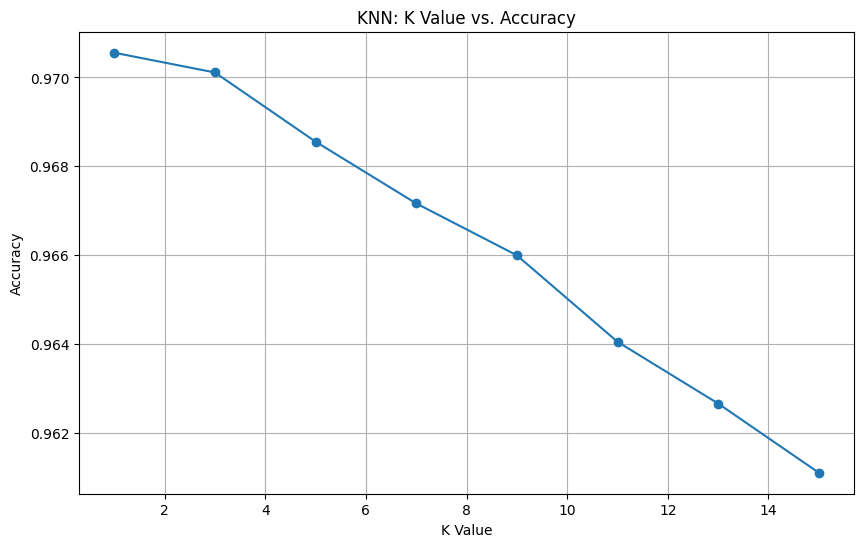

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, knn_accuracies, marker='o')
plt.title('KNN: K Value vs. Accuracy')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# SVM Implementation

In [25]:
from sklearn.preprocessing import StandardScaler

# Apply StandardScaler instead of just normalizing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_eval)
X_test_scaled = scaler.transform(X_test_eval)

print("\n--- SVM Implementation ---")
start_time = time.time()
svm_linear = SVC(kernel='linear', C=1)
svm_linear.fit(X_train_scaled, y_train_eval)
svm_training_time = time.time() - start_time

start_time = time.time()
# Use svm_linear instead of svm
svm_pred = svm_linear.predict(X_test_scaled)  # Also use scaled test data
svm_prediction_time = time.time() - start_time
svm_acc = accuracy_score(y_test_eval, svm_pred)

print(f"SVM Accuracy: {svm_acc:.4f}")
print(f"SVM Training Time: {svm_training_time:.2f} seconds")
print(f"SVM Prediction Time: {svm_prediction_time:.2f} seconds")


--- SVM Implementation ---
SVM Accuracy: 0.9194
SVM Training Time: 124.70 seconds
SVM Prediction Time: 49.81 seconds


# Random Forest Implementation

In [26]:
print("\n--- Random Forest Implementation ---")
start_time = time.time()
rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
rf.fit(X_train_eval, y_train_eval)
rf_training_time = time.time() - start_time

start_time = time.time()
rf_pred = rf.predict(X_test_eval)
rf_prediction_time = time.time() - start_time
rf_acc = accuracy_score(y_test_eval, rf_pred)

print(f"Random Forest Accuracy: {rf_acc:.4f}")
print(f"Random Forest Training Time: {rf_training_time:.2f} seconds")
print(f"Random Forest Prediction Time: {rf_prediction_time:.2f} seconds")


--- Random Forest Implementation ---
Random Forest Accuracy: 0.9641
Random Forest Training Time: 24.34 seconds
Random Forest Prediction Time: 0.53 seconds


# CNN Implementation

In [27]:
cnn_acc = None
cnn_training_time = None
cnn_prediction_time = None
cnn_history = None

if tensorflow_available:
    print("\n--- CNN Implementation ---")
    # Reshape data for CNN
    X_train_cnn = X_train_eval.reshape(-1, img_dim, img_dim, 1)
    X_test_cnn = X_test_eval.reshape(-1, img_dim, img_dim, 1)

    # One-hot encode labels
    y_train_cnn = to_categorical(y_train_eval, num_classes=10)
    y_test_cnn = to_categorical(y_test_eval, num_classes=10)

    # Build CNN model
    cnn_model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_dim, img_dim, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(10, activation='softmax')
    ])

    cnn_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

    # Train CNN model
    start_time = time.time()
    cnn_history = cnn_model.fit(X_train_cnn, y_train_cnn,
                              epochs=10,
                              batch_size=128,
                              validation_split=0.1,
                              verbose=1)
    cnn_training_time = time.time() - start_time

    # Evaluate CNN model
    start_time = time.time()
    cnn_loss, cnn_acc = cnn_model.evaluate(X_test_cnn, y_test_cnn)
    cnn_prediction_time = time.time() - start_time

    print(f"CNN Accuracy: {cnn_acc:.4f}")
    print(f"CNN Training Time: {cnn_training_time:.2f} seconds")
    print(f"CNN Prediction Time: {cnn_prediction_time:.2f} seconds")


--- CNN Implementation ---


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.7849 - loss: 0.7072 - val_accuracy: 0.9710 - val_loss: 0.0854
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9666 - loss: 0.1063 - val_accuracy: 0.9819 - val_loss: 0.0554
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9785 - loss: 0.0664 - val_accuracy: 0.9845 - val_loss: 0.0466
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9831 - loss: 0.0552 - val_accuracy: 0.9871 - val_loss: 0.0412
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9859 - loss: 0.0441 - val_accuracy: 0.9869 - val_loss: 0.0381
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9889 - loss: 0.0352 - val_accuracy: 0.9893 - val_loss: 0.0330
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9907 - loss: 0.0278 - val_accuracy: 0.9893 - val_loss: 0.0339
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9916 - loss: 0.0275 - val_accu

#Plot CNN training History

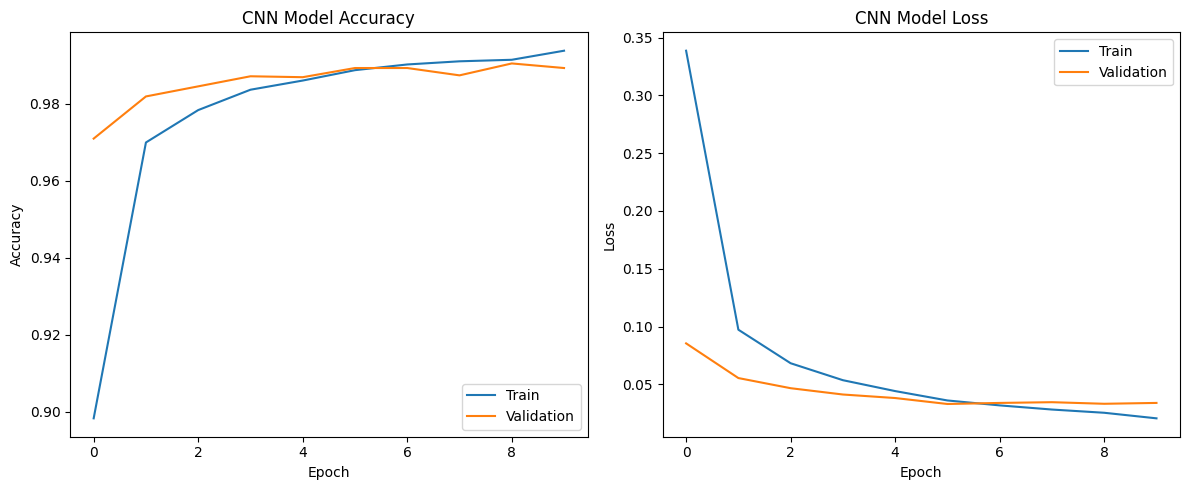

In [28]:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(cnn_history.history['accuracy'])
    plt.plot(cnn_history.history['val_accuracy'])
    plt.title('CNN Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(cnn_history.history['loss'])
    plt.plot(cnn_history.history['val_loss'])
    plt.title('CNN Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.show()

# PCA Implementation for KNN

In [29]:
print("\n--- PCA + KNN Implementation ---")
pca = PCA(n_components=100)  # Reduce to 100 dimensions
X_train_eval_pca = pca.fit_transform(X_train_eval)
X_test_eval_pca = pca.transform(X_test_eval)

print(f"Original dimensions: {X_train_eval.shape[1]}")
print(f"Reduced dimensions: {X_train_eval_pca.shape[1]}")
print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.4f}")

# Train KNN with PCA
start_time = time.time()
knn_pca = KNeighborsClassifier(n_neighbors=optimal_k)
knn_pca.fit(X_train_eval_pca, y_train_eval)
knn_pca_training_time = time.time() - start_time

start_time = time.time()
knn_pca_pred = knn_pca.predict(X_test_eval_pca)
knn_pca_prediction_time = time.time() - start_time
knn_pca_acc = accuracy_score(y_test_eval, knn_pca_pred)

print(f"PCA + KNN Accuracy: {knn_pca_acc:.4f}")
print(f"PCA + KNN Training Time: {knn_pca_training_time:.2f} seconds")
print(f"PCA + KNN Prediction Time: {knn_pca_prediction_time:.2f} seconds")
print(f"Speed improvement: {knn_prediction_time/knn_pca_prediction_time:.2f}x faster")


--- PCA + KNN Implementation ---
Original dimensions: 784
Reduced dimensions: 100
Explained variance ratio: 0.9148
PCA + KNN Accuracy: 0.9728
PCA + KNN Training Time: 0.00 seconds
PCA + KNN Prediction Time: 1.15 seconds
Speed improvement: 7.28x faster


# Algorithm Comparison

In [30]:
# Prepare data for visualization
models = ['KNN', 'PCA+KNN', 'SVM', 'Random Forest']
accuracies = [knn_acc, knn_pca_acc, svm_acc, rf_acc]
training_times = [knn_training_time, knn_pca_training_time, svm_training_time, rf_training_time]
prediction_times = [knn_prediction_time, knn_pca_prediction_time, svm_prediction_time, rf_prediction_time]

# Add CNN if available
if tensorflow_available and cnn_acc is not None:
    models.append('CNN')
    accuracies.append(cnn_acc)
    training_times.append(cnn_training_time)
    prediction_times.append(cnn_prediction_time)

Accuracy Comparison

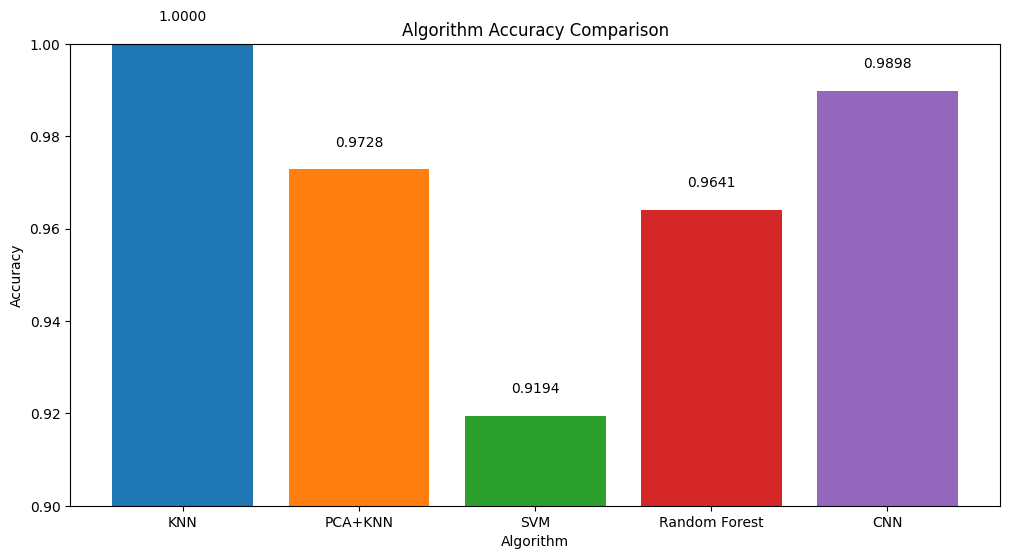

In [31]:
plt.figure(figsize=(12, 6))
plt.bar(models, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.title('Algorithm Accuracy Comparison')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.ylim(0.9, 1.0)  # Adjust as needed
for i, v in enumerate(accuracies):
    plt.text(i, v+0.005, f"{v:.4f}", ha='center')
plt.show()

Training Time Comparison

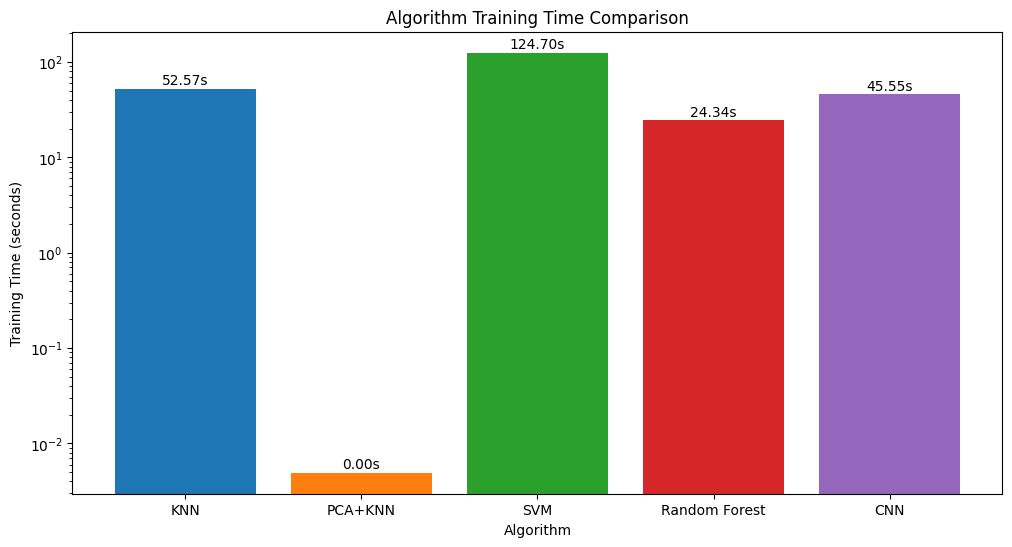

In [32]:
plt.figure(figsize=(12, 6))
plt.bar(models, training_times, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.title('Algorithm Training Time Comparison')
plt.xlabel('Algorithm')
plt.ylabel('Training Time (seconds)')
plt.yscale('log')  # Log scale for better visualization
for i, v in enumerate(training_times):
    plt.text(i, v*1.1, f"{v:.2f}s", ha='center')
plt.show()

Prediction Time Comparison

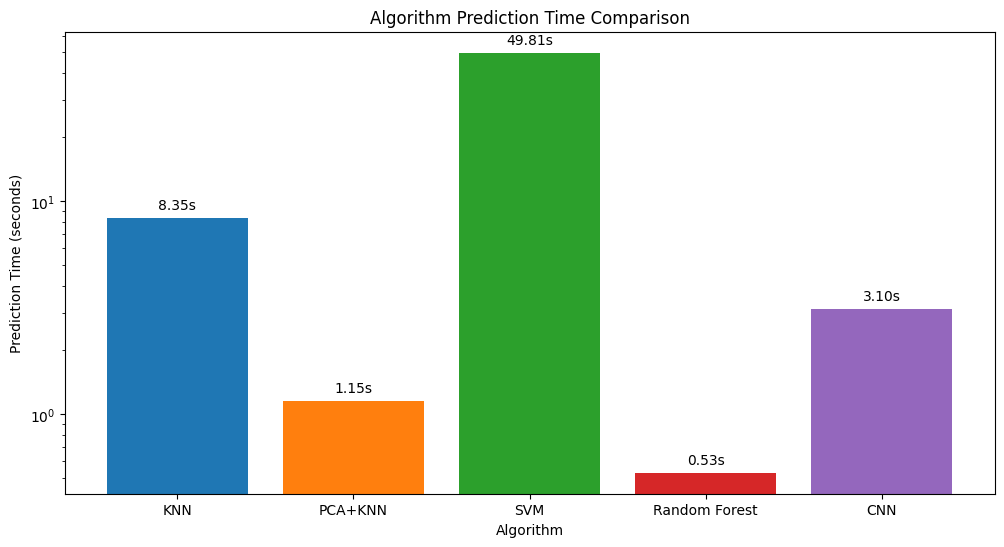

In [33]:
plt.figure(figsize=(12, 6))
plt.bar(models, prediction_times, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.title('Algorithm Prediction Time Comparison')
plt.xlabel('Algorithm')
plt.ylabel('Prediction Time (seconds)')
plt.yscale('log')  # Log scale for better visualization
for i, v in enumerate(prediction_times):
    plt.text(i, v*1.1, f"{v:.2f}s", ha='center')
plt.show()

Confusion Matrix for KNN

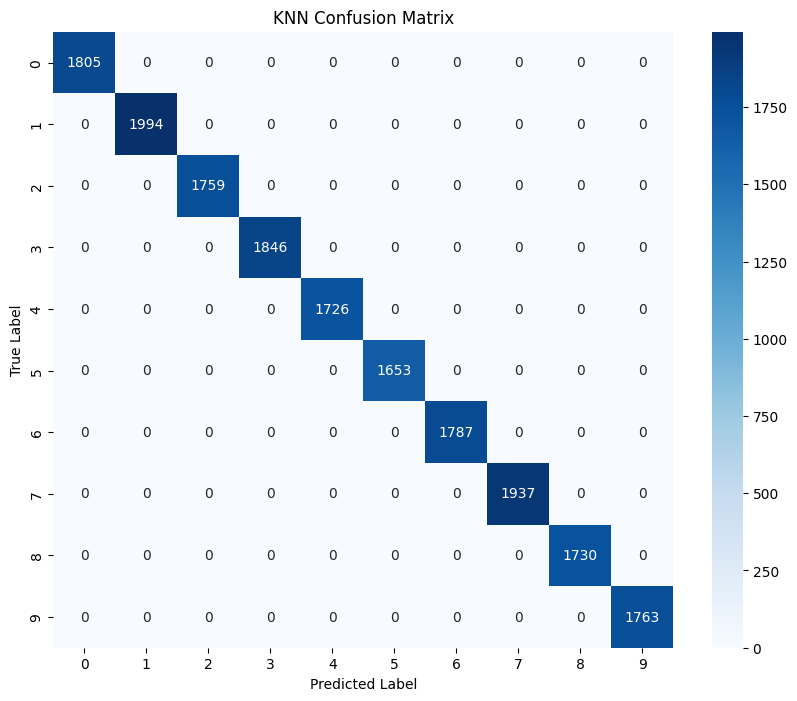

In [34]:
plt.figure(figsize=(10, 8))
knn_cm = confusion_matrix(y_test_eval, knn_pred_eval)
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Blues')
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Classification Reports

In [35]:
print("\n--- Classification Reports ---")
print("KNN Classification Report:")
print(classification_report(y_test_eval, knn_pred_eval))

print("\nSVM Classification Report:")
print(classification_report(y_test_eval, svm_pred))

print("\nRandom Forest Classification Report:")
print(classification_report(y_test_eval, rf_pred))


--- Classification Reports ---
KNN Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1805
           1       1.00      1.00      1.00      1994
           2       1.00      1.00      1.00      1759
           3       1.00      1.00      1.00      1846
           4       1.00      1.00      1.00      1726
           5       1.00      1.00      1.00      1653
           6       1.00      1.00      1.00      1787
           7       1.00      1.00      1.00      1937
           8       1.00      1.00      1.00      1730
           9       1.00      1.00      1.00      1763

    accuracy                           1.00     18000
   macro avg       1.00      1.00      1.00     18000
weighted avg       1.00      1.00      1.00     18000


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1805
           1       0.96      0.98      0.97  

# Visualize misclassified digits

No misclassifications found for KNN


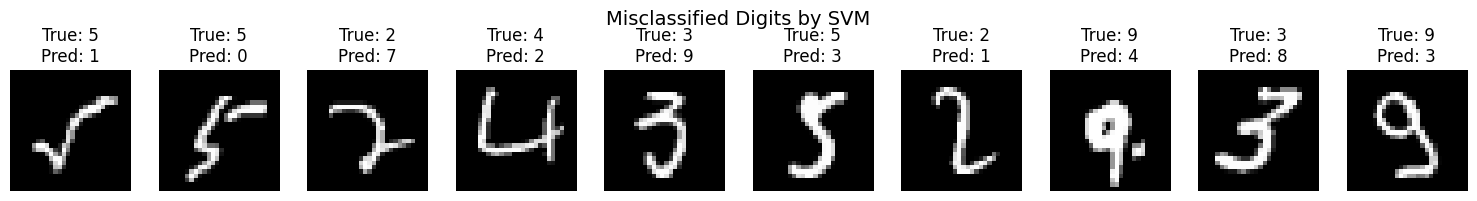

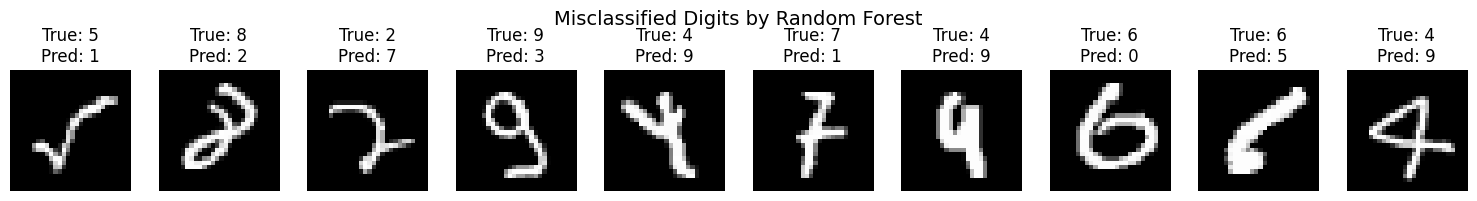

In [36]:
def plot_misclassified(X_test, y_test, y_pred, algorithm_name, num_samples=10):
    misclassified_indices = np.where(y_test != y_pred)[0]
    if len(misclassified_indices) == 0:
        print(f"No misclassifications found for {algorithm_name}")
        return

    num_samples = min(num_samples, len(misclassified_indices))
    plt.figure(figsize=(15, 2))
    plt.suptitle(f'Misclassified Digits by {algorithm_name}', fontsize=14)

    for i, idx in enumerate(misclassified_indices[:num_samples]):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(X_test[idx].reshape(img_dim, img_dim), cmap='gray')
        plt.title(f'True: {y_test[idx]}\nPred: {y_pred[idx]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot misclassified digits for each algorithm
plot_misclassified(X_test_eval, y_test_eval, knn_pred_eval, 'KNN')
plot_misclassified(X_test_eval, y_test_eval, svm_pred, 'SVM')
plot_misclassified(X_test_eval, y_test_eval, rf_pred, 'Random Forest')

# Make predictions on the actual test data (test.csv)

In [37]:
print("\n--- Making Predictions on Test Data ---")
# Using the best model (based on accuracy)
best_model_name = models[np.argmax(accuracies)]
print(f"Using {best_model_name} for final predictions")


--- Making Predictions on Test Data ---
Using KNN for final predictions


# Generate predictions using all models

In [41]:
# Drop the label column from test set (assuming it's named 'label')
X_test = test_df.drop(columns=['label']) if 'label' in test_df.columns else test_df

# Make predictions
knn_test_predictions = knn.predict(X_test)
svm_test_predictions = svm_linear.predict(X_test)
rf_test_predictions = rf.predict(X_test)

# Create DataFrames with predictions
knn_results = pd.DataFrame({'ImageId': range(1, len(X_test) + 1), 'Label': knn_test_predictions})
svm_results = pd.DataFrame({'ImageId': range(1, len(X_test) + 1), 'Label': svm_test_predictions})
rf_results = pd.DataFrame({'ImageId': range(1, len(X_test) + 1), 'Label': rf_test_predictions})

# Save predictions to CSV
knn_results.to_csv('knn_predictions.csv', index=False)
svm_results.to_csv('svm_predictions.csv', index=False)
rf_results.to_csv('rf_predictions.csv', index=False)

print("Predictions saved to CSV files")


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Predictions saved to CSV files


# Summary table

In [42]:
print("\n--- Algorithm Performance Summary ---")
summary_data = {
    'Algorithm': models,
    'Accuracy': [f"{acc:.4f}" for acc in accuracies],
    'Training Time (s)': [f"{t:.2f}" for t in training_times],
    'Prediction Time (s)': [f"{t:.2f}" for t in prediction_times]
}
summary_df = pd.DataFrame(summary_data)
print(summary_df)

# Save the summary to CSV
summary_df.to_csv('algorithm_comparison_summary.csv', index=False)
print("Summary saved to 'algorithm_comparison_summary.csv'")


--- Algorithm Performance Summary ---
       Algorithm Accuracy Training Time (s) Prediction Time (s)
0            KNN   1.0000             52.57                8.35
1        PCA+KNN   0.9728              0.00                1.15
2            SVM   0.9194            124.70               49.81
3  Random Forest   0.9641             24.34                0.53
4            CNN   0.9898             45.55                3.10
Summary saved to 'algorithm_comparison_summary.csv'
